(Different approaches

Consider targeting a few different types of authors:
Don't only consider the reviewers with most
Think about lengthy reviews
Or reviews around the median
Diversity in types of reviews
Similarity across reviewers)

# Unsupervised learning capstone

## Amazon reviews: a study

### A project analyzing product reviews and focusing on clustering, visualization, and word embeddings

#### Data source:

This dataset is a large collection of Amazon reviews in text with the following information:

- Review ID: Unique identifier for review
- ProductID: Unique identifier for product
- UserID: Unique identifier for user
- ProfileName: Self-selected name for reviewer
- HelpfulnessRatings: Values on how helpful others found review
- Score: Ratings 1-5 given by reviewer on product
- Summary: Short title / summary of review
- Review: Full text review

### Capstone goals

#### Primary goals of the capstone are to mine through cleaned text reviews and:

1. Discover trends and clusters of reviews
2. Hypothesize as to reasons why

#### To complete the goals, there are several major steps:

1. Import data
2. Data and text cleaning
3. Text parsing
4. tf-idf fitting and unsupervised modeling
5. Applicable visualizations
6. Conclusions

The steps above are standard to my approach. Steps that are more ad hoc to this exercise are explained as they arise.

In [2]:
import numpy as np
import pandas as pd
import re
import sqlite3
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
sns.set_style('darkgrid')
%matplotlib inline

nlp = spacy.load('en_core_web_sm')

In [3]:
# If we want to work with a sqlite version, we have the option

# conn = sqlite3.connect('../../../amazon-fine-food-reviews/database.sqlite')
# c = conn.cursor()
# c.execute('PRAGMA table_info(reviews)')
# print(c.fetchall())
# c.execute('SELECT * FROM reviews LIMIT 1;')
# c.fetchall()

df_orig = pd.read_csv('../../../amazon-fine-food-reviews/Reviews.csv')
df_orig.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


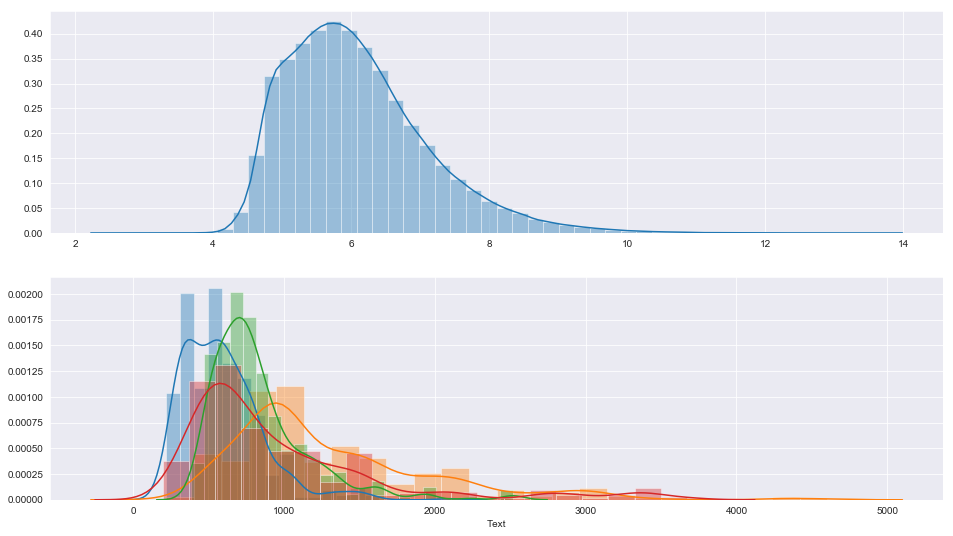

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))
sns.distplot([np.log(len(summary)) for summary in df_orig.groupby(by='UserId')['Text'].sum()], ax=ax1)

for id in df_orig.UserId.value_counts()[:4].index:
    sns.distplot(df_orig[df_orig.UserId == id]['Text'].str.len(), ax=ax2)

In [6]:
# Test spacy, stop words, lemma_, etc.
doc = nlp(df_orig.iloc[0]['Text'])
[token.lemma_.lower() for token in doc if not token.is_punct and not token.is_stop][:6]

['-pron-', 'buy', 'vitality', 'can', 'dog', 'food']

In [7]:
df = df_orig[df_orig.UserId.isin(df_orig.UserId.value_counts()[:12].index)]
print('Length of total text of 12 highest-reviewing: {}.\n'.format(len(df['Text'].str.cat())))
print(df.UserId.value_counts())

Length of total text of 12 highest-reviewing: 4099187.

A3OXHLG6DIBRW8    448
A1YUL9PCJR3JTY    421
AY12DBB0U420B     389
A281NPSIMI1C2R    365
A1Z54EM24Y40LL    256
A1TMAVN4CEM8U8    204
A2MUGFV2TDQ47K    201
A3TVZM3ZIXG8YW    199
A3PJZ8TU8FDQ1K    178
AQQLWCMRNDFGI     176
A2SZLNSI5KOQJT    175
A29JUMRL1US6YP    172
Name: UserId, dtype: int64


## Word length max

Placing tokens and text into memory with spaCy has limits. We will need to keep the word length below one million for this exercise. Below we have a function that takes an index of reviewers and a number of reviews from each to balance samples to return total word length. This lets us know what we can use and expect. We loop this over several numbers to find a good balance of robust text that fits in memory.

In [8]:
def how_long(index_len, long, df=df_orig, return_='n'):
    assert type(long) == int
    index_list = df.UserId.value_counts()[:index_len].index
    df_list = []
    for index in index_list:
        df_sample = df[df.UserId == index].sample(n=long)
        df_list.append(df_sample)
    df_new = pd.concat(df_list)
    print("The dataframe with {} samples from each reviewer is a total of {} words long.".
          format(long, len(df_new['Text'].str.cat())))
    if return_ == 'y':
        return df_new

for val in range(10, 100, 10):
    how_long(15, val)

The dataframe with 10 samples from each reviewer is a total of 188507 words long.
The dataframe with 20 samples from each reviewer is a total of 361249 words long.
The dataframe with 30 samples from each reviewer is a total of 540889 words long.
The dataframe with 40 samples from each reviewer is a total of 734974 words long.
The dataframe with 50 samples from each reviewer is a total of 915198 words long.
The dataframe with 60 samples from each reviewer is a total of 1080119 words long.
The dataframe with 70 samples from each reviewer is a total of 1284832 words long.
The dataframe with 80 samples from each reviewer is a total of 1490826 words long.
The dataframe with 90 samples from each reviewer is a total of 1656549 words long.


In [9]:
df = how_long(15, 52, return_='y') 

The dataframe with 52 samples from each reviewer is a total of 970214 words long.


## Samples from each reviewer: 52

Pulling 52 samples from each reviewer yields slightly fewer than one million words. This is the target.

## Reviewing the samples

After poking around the text and using regular expressions to clean up, I noticed some issues with duplication:

In [14]:
kab_list = df[df.Text.str.contains('Kaboodle')].index[:2]
df[df.Text.str.contains('Kaboodle')]['Text'][kab_list[0]] == df[df.Text.str.contains('Kaboodle')]['Text'][kab_list[1]]

True

In [15]:
for user in df_orig.UserId.value_counts()[:3].index:
    print(user, '  ', df_orig[df_orig.UserId == user]['Text'].duplicated().value_counts(), '\n')

A3OXHLG6DIBRW8    False    268
True     180
Name: Text, dtype: int64 

A1YUL9PCJR3JTY    True     227
False    194
Name: Text, dtype: int64 

AY12DBB0U420B    False    329
True      60
Name: Text, dtype: int64 



## Duplicates

One single reviewer had many identical reviews. Upon closer inspection, *many* reviews were duplicated by the same authors, as we can see with the duplicated() function and loop. This could be a result of copy/paste reviewing on the site, or it could be an input error. Either way, it can lead to lower text variation and cause imbalance later in word embeddings and term frequencies. 

## Removing duplicates? 

Should we remove the duplicates? Before researching specific duplicates and determining the underlying issue, let's approach the problem and try to answer the more important question first - *can we still set up an environment with enough data to cluster reviews, reviewers, and study text differences after removing duplicates?* This is somewhat more academic, after all.

In [16]:
df_nodup = df_orig.drop_duplicates(['UserId', 'Text'])
df_nodup.dropna(inplace=True)
df_nodup.info()

C:\Users\clayp\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<class 'pandas.core.frame.DataFrame'>
Int64Index: 393592 entries, 0 to 568453
Data columns (total 10 columns):
Id                        393592 non-null int64
ProductId                 393592 non-null object
UserId                    393592 non-null object
ProfileName               393592 non-null object
HelpfulnessNumerator      393592 non-null int64
HelpfulnessDenominator    393592 non-null int64
Score                     393592 non-null int64
Time                      393592 non-null int64
Summary                   393592 non-null object
Text                      393592 non-null object
dtypes: int64(5), object(5)
memory usage: 33.0+ MB


In [17]:
df = how_long(15, 55, df_nodup, 'y')

The dataframe with 55 samples from each reviewer is a total of 632808 words long.


## Dropping duplicates - 15 reviewers, 55 reviews

After dropping all duplicates *based on those from one reviewer* and removing NaN values, we can work with the busiest 15 reviewers and still have north of 600,000 words to analyze. This isn't as many as before, but it should be healthy enough for analysis and text mining.

## Regular expressions cleanup

In [21]:
def cleaner(text):
    try:
        mytext = text.str.cat(sep=' ')
    except:
        mytext = text
    mytext = re.sub(r'<br />', ' ', mytext)
    mytext = re.sub(r'<a href=', ' ', mytext)
    mytext = re.sub(r'[^A-Za-z0-9 ":/.*".\'.]', ' ', mytext)
    mytext = re.sub(r'/a', '', mytext)
    mytext = re.sub('   ', ' ', mytext)
    mytext = re.sub('  ', ' ', mytext)
    return mytext

mytext = cleaner(df['Text'])
doc = nlp(mytext)
# Preview the cleanup to see if it is only sentences
mytext[:500]

"I've always liked Trisquits. It goes way way back at least 70 years to my childhood. My mother always thought they were better for us than plain white saltine crackers. I think she was right. I like the saltyness the flavor and the crunchy texture. Thus it was when I found some Triscuit Cracked Pepper and Olive Oil crackers 9.0 ounce box at a nearby Fresh and Easy store. Oh that sounded good. Well they were Excellent All the good texture and flavor of the Standard Triscuit plus the bracing taste"

## Web links and other characters

I wanted to preserve links in case some of the links happened very frequently. It was also critical to preserve these in their original form as splitting www.amazon.com/link/ along punctuation might generate unwanted words, like 'amazon'.

### Difficult lesson

In the two boxes below, we learn a hard lesson in using gensim and spaCy. List comprehensions alone - without lists of sentences - had Word2Vec models create vocabularies of letters and characters. This was very much unwanted behavior, taking up several hours of processing and just a few minutes of using Google to figure out why. Beyond this issue, we are again smooth sailing.

In [38]:
'''These loops took hours!
for token in doc:
    doc_list = [token.lemma_.lower() for token in doc if not token.is_punct and not token.is_stop]

for token in doc.sents:
    doc_list3 = [token.lemma_.lower() for token in doc if not token.is_punct and not token.is_stop]'''
    
import pickle

# with open('words', 'wb') as file:
#     pickle.dump(doc_list, file)
    
with open('words', 'rb') as file:
    doc_list2 = pickle.load(file)
    
# with open('sents', 'wb') as file:
#     pickle.dump(doc_list3, file)
    
with open('sents', 'rb') as file:
    doc_list4 = pickle.load(file)

In [39]:
# Faulty model that caused a bit of confusion! Bad inputs and preprocessing will do this
model2 = Word2Vec(doc_list4, workers=3, min_count=1, size=300)
model2.wv.vocab.keys()

dict_keys(['-', 'p', 'r', 'o', 'n', 's', 'y', 'e', 'a', 'l', 'd', 't', 'i', 'f', 'w', 'h', 'c', 'g', 'k', 'u', 'v', 'b', 'z', 'j', 'm', 'x', "'", '7', '3', '2', '4', '1', '.', '5', '0', '9', 'q', '6', '8', '"', ':', '/', ' ', '*'])

## Corrected input and model
### We now will use a list of nested sentences, what is needed for Word2Vec

In [22]:
doc_list5 = []
for sentence in doc.sents:
    app = [token.lemma_.lower() for token in sentence if not token.is_punct and not token.is_stop]
    doc_list5.append(app)
    
model = Word2Vec(doc_list5)
model.wv.most_similar(positive=['steak'], negative=['admit'])

[('mmmmm', 0.07101459801197052),
 ('england', 0.06343016028404236),
 ('understand', 0.057835906744003296),
 ('omega', 0.057794149965047836),
 ('bitterness', 0.056705325841903687),
 ('unclear', 0.05611554533243179),
 ('tube', 0.055978577584028244),
 ('sadly', 0.054240431636571884),
 ('imagination', 0.05371968075633049),
 ('spiced', 0.052989788353443146)]

## Testing working model

#### Run cosine similarity tests on several words to see if we have varying values

In [23]:
model.wv.similarity('salad', 'corn')

0.9998889462690495

In [24]:
model.wv.similarity('salad', 'meat')

0.9998408283093616

In [25]:
model.wv.similarity('salad', 'wonder')

0.9994805362067762

In [27]:
model.wv.similarity('walk', 'double')

0.9852686529252558

## Very similar cosine similarities

#### Create new model with a more robust input

The new corporus will drop down to only 10 authors and include more of their content to see if we can improve.

In [28]:
df = how_long(10, 68, return_='y')
mytext = cleaner(df['Text'])
doc = nlp(mytext)
sentences = []
for sentence in doc.sents:
    sentences.append([token.lemma_.lower() for token in sentence if not token.is_punct and not token.is_stop])
    
model = Word2Vec(sentences)

The dataframe with 68 samples from each reviewer is a total of 975559 words long.


In [29]:
model.wv.similarity('steak', 'breakfast')

0.9318677060124656

In [30]:
model.wv.similarity('salad', 'wonder')

0.9698376377562362

In [31]:
model = Word2Vec(sentences, size=300, window=6, min_count=1, sg=0, sample=1e-3)

In [32]:
model.wv.similarity('literally', 'bean')

0.7948593892616973

In [33]:
model.wv.similarity('steak', 'breakfast')

0.9702115148630089

In [34]:
model.wv.similarity('sugar', 'bored')

0.4316831376845946

In [39]:
model.wv.similarity(cleaner(df.iloc[24]['Text']), cleaner(df.iloc[42]['Text']))

KeyError: 'word \'This DaVinci sugar free Kahlua syrup is a great way to add a bit of flavor to otherwise boring "dietetic" drinks and snacks. Being a Type 2 diabetic I have to watch my sugar intake and have found that these types of flavorings can significantly improve my enjoyment of healthy foods like plain yogurt and yet also satisfy my sweet tooth. The Kahlua flavor is very realistic tasting and the Splenda does not leave an "aftertaste" like other artificial sweeteners at least to me . Highly Recommended CFH\' not in vocabulary'

In [45]:
df['Text'][3926]

'Hershey "Sugar Free Caramel Filled Chocolates" are very good diabetic friendly chocolate candies. These are fairly small, but are very tasty.<br /><br />Sweetened with Splenda, these do not significantly impact my blood sugar levels or cause gastric distress.<br /><br />Highly Recommended!<br /><br />CFH'

## Similars from different authors

Which reviews - one from each author - are most similar?

## Graphing

One vs all in terms of similarities or graph them all separately

## Unsupervised methods?

tf-idf and LSA vs word2vec stuff

## Do clusters revolve around the same authors or scores?

Consider these questions